# Projeto Prático AceleraDev Data Science


__Problema de aprendizado não supervesionado:__ clustering
- market tem todas as empresas
- portfolio 1, 2, 3 são os clientes de cada empresa.

__Descobrir:__
- Quantidade de campos nulos em cada um dos porfolios

__Testar:__
- SVM na base de market: testar para entender se são classes separáveis
    - Colocar label de qual empresa aquela empresa é cliente
    - Colocar label de não explorado para as que nao tem alocação
    - Aplicar PCA com SVM 
    
__Solução final:__
- Receber uma lista com clientes atuais
- Tratar os dados recebidos via pipeline
- Encontrar cluster pros dados recebidos
- Classificar nos cluster a base nova

# Entendo as bases de dados
## Uma empresa pode estar em mais de um portfólio?

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

#Configuracoes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

C:\Users\herna\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Funcoes utilizadas 
def missing_data(df):    
    missing_data = pd.DataFrame({'Tipo': df.dtypes,'Dados faltantes (%)': (df.isna().sum() / df.shape[0])*100})
    missing_data.sort_values(by='Dados faltantes (%)', inplace=True, ascending=False)
    return missing_data

def sumary_df(df):
    print("Informações básicas do dataset")
    print("\nFormato:", df.shape)
    display(df.head(5))
    
    print("\nTipos de dados:")
    display(df.info())

    print("\nPercentual de dados faltantes:")
    display(missing_data(df).T)

    print("\nEstatísticas das features:")
    display(df.describe())

In [3]:
market = pd.read_csv('data/estaticos_market.csv')
pf1 = pd.read_csv('data/estaticos_portfolio1.csv')
pf2 = pd.read_csv('data/estaticos_portfolio2.csv')
pf3 = pd.read_csv('data/estaticos_portfolio3.csv')

In [4]:
S1 = set(pf1['id'])
S2 = set(pf2['id'])
S3 = set(pf3['id'])

nome = ['Portófio 1', 'Portófio 2', 'Portófio 3']

linha_1 = pd.DataFrame([len(S1), len(S1.intersection(S2)), len(S1.intersection(S3))], index=nome, columns=['Portfólio 1'])
linha_2 = pd.DataFrame([len(S2.intersection(S1)), len(S2), len(S2.intersection(S3))], index=nome, columns=['Portfólio 2'])
linha_3 = pd.DataFrame([len(S3.intersection(S1)), len(S3.intersection(S2)), len(S3)], index=nome, columns=['Portfólio 3'])

quadro_comparativo = pd.concat([linha_1, linha_2, linha_3], axis=1)

In [5]:
print("Total de empresas no mercado: ", market.shape[0])
print("Relação entre os portólios:")
quadro_comparativo

Total de empresas no mercado:  462298
Relação entre os portólios:


,Portfólio 1,Portfólio 2,Portfólio 3
Portófio 1,555,0,0
Portófio 2,0,566,108
Portófio 3,0,108,265


A partir do quadro acima, pode-se dizer que:
- Uma empresa pode estar em mais de um portfólio.
- Os portfólios 2 e 3 possuem empresas em comum.
- Empresas do portfólio 1, não podem estar nos outros dois.
- Maioria das empresas do mercado não estão dentro dos portfólios.

# Estratégias que serão adotadas

Para a resolução deste desafio, duas etapadas serão desenvolvidas:

1. Criação de clusters para identificar quais os tipos de empresas existentes.
2. Modelo de classificação de empresas.

Na primeira etapa, será usado o algoritmo não supervisionado K-means para identificar a existência de diferentes clusters. Nesta fase, quanto maior o número de clusters encontrados, respeitando o critério do gráfico de _elbow_ melhor. A forma de avaliação da eficácia da abordagem é a seguinte:

- As empresas do portfólio 1 não devem estar no mesmo clusters que as empresas dos porfólios 2 e 3.
- Algumas empresas do portfólio 2 podem estar no cluster do portfólio 3 e vice versa.
- Espera-se encontrar mais de 3 clusters, devido ao espaço amostraço do mercado, comparado com os portfólios.

Na segunda etapa, as empresas serão usadas para criar um modelo de classificação, baseado nos clusters encontrados. Espera-se a mesma avaliação que a etapa 1.

## Etapa 1: K-means
Serão testados 4 tipos de abordagem na tratativa dos dados:
1. Features usando one-hot encoding 
2. Features usando one-hot encoding e variáveis normalizadas
3. Features usando label encoding
4. Features usando label encoding e variáveis normalizdas


## Etapa 2: Algoritmos de classificação
As seguintes abordagens serão testadas
- Árvores de decisão: decision tree, random forest, Xgboost
- SVM
- KNN


# Separando dados de treino e teste
1. Separar 70% de cada portfólio
2. Remover o que não estiver dentro do dataframe de market

In [6]:
# Separando treino e teste
pf1_train, pf1_test, = train_test_split(pf1, test_size=0.33, random_state=42)
pf2_train, pf2_test, = train_test_split(pf2, test_size=0.33, random_state=42)
pf3_train, pf3_test, = train_test_split(pf3, test_size=0.33, random_state=42)

In [7]:
print(market.shape)
# Removendo teste da base de market
id1 = pf1_test['id']
id2 = pf2_test['id']
id3 = pf3_test['id']
market = market.query("id not in @id1")
market = market.query("id not in @id2")
market = market.query("id not in @id3")
print(market.shape)

(462298, 182)
(461851, 182)


# Executando transformações de variáveis:
1. Variáveis que possuem mais de 35% de valores nulos são eliminadas.
2. Das amostras restantes, as que possuem valores nulos na coluna referente ao imposto de ISS são removidas dos dados de treinamento.
3. Algumas colunas recebem imputação de dados, usando a mediana dos valores não nulos.
4. Variáveis categóricas são transformadas em números, usando label encoding.

In [8]:
features_nulas = missing_data(market)
features_nulas = features_nulas[features_nulas['Dados faltantes (%)'] >= 31.5].index

drop_columns = ['Unnamed: 0', 'dt_situacao', 'de_faixa_faturamento_estimado_grupo', 'qt_socios']

sim_to_int = ['fl_rm']

bool_to_int = ['fl_matriz', 'fl_me', 'fl_sa', 'fl_epp', 'fl_mei', 'fl_ltda', 'fl_st_especial', 'fl_email', 
               'fl_telefone', 'fl_spa', 'fl_antt', 'fl_veiculo', 'fl_simples_irregular', 'fl_passivel_iss', 
               'fl_optante_simei', 'fl_optante_simples']

nan_to_zero = ['empsetorcensitariofaixarendapopulacao', 'fl_optante_simei', 'fl_optante_simples',
               'vl_total_veiculos_leves_grupo']

nan_to_mediana = ['vl_faturamento_estimado_aux', 'vl_faturamento_estimado_grupo_aux', 'qt_socios_pj',
                  'qt_socios_pf', 'nu_meses_rescencia']


label_encoding = ['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 'de_ramo', 'setor',
                    'nm_divisao', 'nm_segmento', 'sg_uf_matriz', 'de_saude_tributaria', 'nm_meso_regiao', 'nm_micro_regiao']


In [9]:
# Estado inicial do dataset
df = market.copy()

In [10]:
# Exclusao de features
df.drop(columns=drop_columns, inplace=True)
df.drop(columns=features_nulas, inplace=True)

# Exclusao de nulos nao produtivos
df = df[~df['fl_passivel_iss'].isna()]


# Imputando dados nulos
df[nan_to_zero] = df[nan_to_zero].fillna(0)
df[nan_to_mediana] = df[nan_to_mediana].fillna(df[nan_to_mediana].mean())


# Transformando dados - label encoding
df[bool_to_int] = df[bool_to_int].replace({True:1, False:0})
df[sim_to_int] = df[sim_to_int].replace({'SIM':1, 'NAO':0})
df['idade_emp_cat'] = df['idade_emp_cat'].replace({'> 20':20})

df['idade_emp_cat'] = df['idade_emp_cat'].replace({'<= 1': 1, '1 a 5': 2, '5 a 10': 3, '10 a 15': 4, '15 a 20': 5})
df['de_saude_rescencia'] = df['de_saude_rescencia'].replace({'ACIMA DE 1 ANO':5, 'ATE 1 ANO':4, np.nan:0, 'SEM INFORMACAO':1,
                                                             'ATE 3 MESES': 2, 'ATE 6 MESES': 3})
df['de_nivel_atividade'] = df['de_nivel_atividade'].replace({'ALTA': 4, 'BAIXA': 2, 'MEDIA': 3, np.nan: 0, 'MUITO BAIXA': 1})
df['de_faixa_faturamento_estimado'] = df['de_faixa_faturamento_estimado'].replace({ np.nan: 0,
 'SEM INFORMACAO': 1,
 'ATE R$ 81.000,00': 2,
 'DE R$ 81.000,01 A R$ 360.000,00': 3,
 'DE R$ 360.000,01 A R$ 1.500.000,00': 4,
 'DE R$ 1.500.000,01 A R$ 4.800.000,00': 5,
 'DE R$ 4.800.000,01 A R$ 10.000.000,00': 6,
 'DE R$ 10.000.000,01 A R$ 30.000.000,00': 7,
 'DE R$ 30.000.000,01 A R$ 100.000.000,00': 8,
 'DE R$ 100.000.000,01 A R$ 300.000.000,00': 9,
 'DE R$ 300.000.000,01 A R$ 500.000.000,00': 10,
 'DE R$ 500.000.000,01 A 1 BILHAO DE REAIS': 11,
 'ACIMA DE 1 BILHAO DE REAIS': 12})

In [11]:
le = preprocessing.LabelEncoder()

df[label_encoding] = df[label_encoding].fillna('nulo')
for i in label_encoding:
    df[i] = le.fit_transform(df[i])

In [12]:
X = df.iloc[:, 1:]

scaler = preprocessing.RobustScaler()
df_normalized = scaler.fit_transform(X)
df_normalized = pd.DataFrame(df_normalized, columns=X.columns)

In [13]:
X

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios_pf,qt_socios_pj,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,1,59,4,2,11,2,14.457534,4,0,0,0,0,0,0,1,1,1,32,10,0,0,0,1,0.0,0.0,0,19,4,5,23.000000,4,0,0.00,6,48,1,2.000000,0.000000,5,3132172.8,3132172.8,0
1,1,17,3,5,20,4,1.463014,2,0,0,0,1,0,0,1,1,1,3,3,0,0,0,0,0.0,0.0,0,16,2,4,9.000000,2,0,468.93,4,69,1,1.000000,0.000000,3,210000.0,210000.0,0
2,1,17,1,5,31,4,7.093151,3,0,0,0,1,0,0,0,1,1,86,20,0,0,0,1,0.0,0.0,1,2,0,5,26.000000,3,0,713.50,2,43,1,1.000000,0.000000,2,50000.0,50000.0,0
3,1,17,1,5,24,4,6.512329,3,0,0,0,0,0,0,1,1,1,74,17,0,0,0,1,0.0,0.0,0,2,0,5,26.000000,3,0,475.73,2,43,1,1.000000,0.000000,3,210000.0,210000.0,0
4,1,17,4,5,26,4,3.200000,2,0,0,0,0,0,0,1,1,1,77,8,0,0,0,1,0.0,0.0,0,19,4,5,27.000000,4,0,2874.04,6,48,1,1.000000,0.000000,3,210000.0,210000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462293,1,17,4,5,3,1,3.254795,2,0,0,0,1,0,0,1,1,0,28,9,0,0,0,1,0.0,0.0,1,19,4,5,22.000000,4,0,585.63,0,14,0,1.000000,0.000000,2,50000.0,50000.0,0
462294,1,17,3,5,19,4,8.953425,3,0,0,0,0,0,0,0,0,1,76,5,0,0,0,0,0.0,0.0,0,16,3,5,23.000000,1,0,2429.89,4,69,1,1.476764,0.019614,3,210000.0,210000.0,0
462295,1,0,2,3,23,4,20.745205,20,0,0,0,0,0,0,0,0,1,11,18,0,0,0,0,0.0,0.0,0,9,0,5,23.000000,3,0,3150.81,8,0,1,1.000000,0.000000,3,210000.0,210000.0,0
462296,1,59,5,2,5,1,1.909589,2,0,0,0,0,0,0,1,0,0,30,9,0,0,0,0,0.0,0.0,0,20,4,5,20.000000,4,0,2752.49,19,73,0,5.000000,0.000000,4,432734.4,432734.4,0


In [14]:
df_normalized

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios_pf,qt_socios_pj,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,0.0,42.0,0.5,-1.5,0.3750,0.000000,0.675599,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.250,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.3,0.666667,0.0,0.000000,1.0,0.0,-0.591090,-0.250,0.15625,0.0,2.097472,0.0,2.0,119.066302,78.391192,0.0
1,0.0,0.0,0.0,0.0,0.9375,0.666667,-0.449134,-0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-3.375,-1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.0,-4.655413,-1.0,0.0,-0.194297,-0.500,0.81250,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,-1.0,0.0,1.6250,0.666667,0.038179,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.000,2.75,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.4,-0.666667,0.0,0.997589,0.0,0.0,0.012650,-0.750,0.00000,0.0,0.000000,0.0,-1.0,-6.519330,-4.292214,0.0
3,0.0,0.0,-1.0,0.0,1.1875,0.666667,-0.012094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.500,2.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.4,-0.666667,0.0,0.997589,0.0,0.0,-0.188543,-0.750,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.5,0.0,1.3125,0.666667,-0.298791,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.875,-0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.3,0.666667,0.0,1.330118,1.0,0.0,1.840828,-0.250,0.15625,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459919,0.0,0.0,0.5,0.0,-0.1250,-0.333333,-0.294048,-0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.250,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.666667,0.0,-0.332530,1.0,0.0,-0.095549,-1.000,-0.90625,-1.0,0.000000,0.0,-1.0,-6.519330,-4.292214,0.0
459920,0.0,0.0,0.0,0.0,0.8750,0.666667,0.199194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,5.750,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,-2.0,0.0,1.465003,-0.500,0.81250,0.0,1.000000,1.0,0.0,0.000000,0.000000,0.0
459921,0.0,-17.0,-0.5,-1.0,1.1250,0.666667,1.219825,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-2.375,2.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7,-0.666667,0.0,0.000000,0.0,0.0,2.075021,0.000,-1.34375,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
459922,0.0,42.0,1.0,-1.5,0.0000,-0.333333,-0.410481,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.666667,0.0,-0.997589,1.0,0.0,1.737976,1.375,0.93750,-1.0,8.389889,0.0,1.0,9.075494,5.975148,0.0


# K-means
## Encontrando o número ideal de clusters
Após algumas experiências, chegou-se a conclusão que é possível utilizar 7 clusters

In [15]:
# Instantiate the clustering model and visualizer
#model = KMeans()
#visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')

#visualizer.fit(df_normalized)        # Fit the data to the visualizer
#visualizer.show()

## Gerando clusters

In [16]:
clusters = KMeans(n_clusters=7, random_state=170, max_iter=1000, tol=1e-9, init='k-means++').fit_predict(df_normalized)

In [17]:
df['kmeans'] = clusters
df['kmeans'].value_counts()

0    457025
6      1384
2       565
5       334
1       291
3       191
4       134
Name: kmeans, dtype: int64

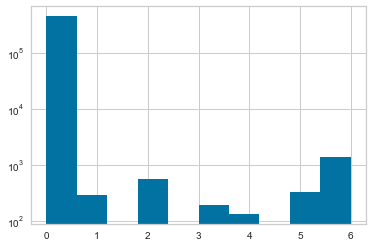

In [18]:
plt.hist(df['kmeans'])
plt.yscale('log')
plt.show()

In [19]:

len(clusters)


459924

In [20]:
len(df_normalized)

459924

In [21]:
df_normalized

,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios_pf,qt_socios_pj,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais
0,0.0,42.0,0.5,-1.5,0.3750,0.000000,0.675599,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.250,0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.3,0.666667,0.0,0.000000,1.0,0.0,-0.591090,-0.250,0.15625,0.0,2.097472,0.0,2.0,119.066302,78.391192,0.0
1,0.0,0.0,0.0,0.0,0.9375,0.666667,-0.449134,-0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-3.375,-1.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.0,-4.655413,-1.0,0.0,-0.194297,-0.500,0.81250,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.0,-1.0,0.0,1.6250,0.666667,0.038179,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,7.000,2.75,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.4,-0.666667,0.0,0.997589,0.0,0.0,0.012650,-0.750,0.00000,0.0,0.000000,0.0,-1.0,-6.519330,-4.292214,0.0
3,0.0,0.0,-1.0,0.0,1.1875,0.666667,-0.012094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.500,2.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.4,-0.666667,0.0,0.997589,0.0,0.0,-0.188543,-0.750,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.5,0.0,1.3125,0.666667,-0.298791,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,5.875,-0.25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.3,0.666667,0.0,1.330118,1.0,0.0,1.840828,-0.250,0.15625,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459919,0.0,0.0,0.5,0.0,-0.1250,-0.333333,-0.294048,-0.5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.250,0.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3,0.666667,0.0,-0.332530,1.0,0.0,-0.095549,-1.000,-0.90625,-1.0,0.000000,0.0,-1.0,-6.519330,-4.292214,0.0
459920,0.0,0.0,0.0,0.0,0.8750,0.666667,0.199194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,5.750,-1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,-2.0,0.0,1.465003,-0.500,0.81250,0.0,1.000000,1.0,0.0,0.000000,0.000000,0.0
459921,0.0,-17.0,-0.5,-1.0,1.1250,0.666667,1.219825,8.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,-2.375,2.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7,-0.666667,0.0,0.000000,0.0,0.0,2.075021,0.000,-1.34375,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0
459922,0.0,42.0,1.0,-1.5,0.0000,-0.333333,-0.410481,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.666667,0.0,-0.997589,1.0,0.0,1.737976,1.375,0.93750,-1.0,8.389889,0.0,1.0,9.075494,5.975148,0.0


## Baseline de resultados

1. Remover variáveis com 100% de nulos
2. Transformar variáveis
1. Marcar base com porftóflios que ja tem
3. Aplicar Kmeans + classificao
4. Avaliar classificação e quantidade de clusters

In [22]:
# Marcando base de dados
aux1 = pf1_train['id']
classe_1 = df.query("id in @aux1").index
classe_1 = classe_1.to_series()


aux2 = pf2_train['id']
classe_2 = df.query("id in @aux2").index
classe_2 = classe_2.to_series()


aux3 = pf3_train['id']
classe_3 = df.query("id in @aux3").index
classe_3 = classe_3.to_series()


df = pd.concat([df, classe_1, classe_2, classe_3], ignore_index=False, axis=1)
df.rename(columns={0: "Pf1", 1: "Pf2", 2: "Pf3"}, inplace=True)


values = {'Pf1': 0, 'Pf2': 0, 'Pf3': 0}
df.fillna(value=values, inplace=True)


df['Sem_Pf'] = ((df['Pf1'] == 0) & (df['Pf2'] == 0) & (df['Pf3'] == 0 )).astype(int)


df['Pf1'] = (df['Pf1'] != 0).astype(int)
df['Pf2'] = (df['Pf2'] != 0).astype(int)
df['Pf3'] = (df['Pf3'] != 0).astype(int)

In [31]:
df[(df['Pf2'] == 1) & (df['kmeans'] != 0) ]

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,fl_sa,fl_epp,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,nm_divisao,nm_segmento,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_saude_rescencia,nu_meses_rescencia,de_nivel_atividade,fl_simples_irregular,empsetorcensitariofaixarendapopulacao,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,qt_socios_pf,qt_socios_pj,de_faixa_faturamento_estimado,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux,qt_filiais,kmeans,Pf1,Pf2,Pf3,Sem_Pf
328810,3dd35d1466158f751559ff54a375e601da1f9bb5d8988f...,1,53,2,2,5,1,12.701370,4,0,1,0,0,0,0,1,1,1,30,9,0,0,0,0,1.0,0.0,0,9,4,5,24.0,4,0,626.64,8,0,1,3.000000,0.000000,10,3.068293e+08,4.663801e+09,116,6,0,1,0,0
418067,ae0d137550d5d5f013585a95ab5ec9edb4c5a1d286fcf2...,1,41,1,0,0,4,23.312329,20,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,5.0,21.0,0,2,1,5,23.0,4,0,2942.61,2,43,1,1.476764,0.019614,12,3.490930e+09,3.519985e+09,121,6,0,1,0,0


In [24]:
#missing_data(df)

In [25]:
#delete


# K-means
- Tratrar dados antes
- plicar k-means